In [1]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [2]:
import warnings

import numpy as np
import pandas as pd
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
setup_drawdown(model)
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

# Make ETC complex II irreversible, complex I reversible
model.reactions.get_by_id("RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.").bounds = (-1000, 0)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40.").bounds = (-1000, 1000)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-6/PROTON//NAD/UBIQUINOL-30.43.").bounds = (-1000, 1000)
model.reactions.get_by_id("1.6.99.5-RXN-NADH/UBIQUINONE-9/PROTON//NAD/CPD-9957.39.").bounds = (-1000, 1000)

# Make 1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56. irreversible
model.reactions.get_by_id("1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56.").bounds = (0, 1000)

# Change/remove all reactions so as to use ubiquinone 10 only
model.remove_reactions([
    "1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-6//ETF-Oxidized/UBIQUINOL-30/PROTON.59.",
    "1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-9//ETF-Oxidized/CPD-9957/PROTON.55.",
    "1.6.99.5-RXN-NADH/UBIQUINONE-6/PROTON//NAD/UBIQUINOL-30.43.",
    "1.6.99.5-RXN-NADH/UBIQUINONE-9/PROTON//NAD/CPD-9957.39.",
    "2.1.1.64-RXN",
    "DHHB-METHYLTRANSFER-RXN",
    "RXN3O-102",
    "RXN66-550-ETF-Reduced/UBIQUINONE-8//ETF-Oxidized/CPD-9956/PROTON.55.",
    "SUCCINATE-DEHYDROGENASE-UBIQUINONE6-RXN"
])
# Add new ETC reactions
ubiquinones = [model.metabolites.get_by_id(ubi)
                for ubi in [
                    "UBIQUINONE-6[c]",
                    "UBIQUINONE-8[c]",
                    "UBIQUINONE-9[c]",
                    "UBIQUINONE-10[c]"]]
ubiquinols = [model.metabolites.get_by_id(ubi)
                for ubi in [
                    "UBIQUINOL-30[c]",
                    "CPD-9956[c]",
                    "CPD-9957[c]",
                    "CPD-9958[c]"
                ]]

reactions_to_change = [
    "RXN-14903-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67.",
    "RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31.",
    "RXN-20992-CPD-9956/OXYGEN-MOLECULE//UBIQUINONE-8/WATER.45.",
]
for rxn_id in reactions_to_change:
    rxn = model.reactions.get_by_id(rxn_id)
    metabolites_copy = rxn.metabolites.copy()
    for met, coeff in metabolites_copy.items():
        if met in ubiquinones:
            rxn.add_metabolites({met : -coeff, model.metabolites.get_by_id("UBIQUINONE-10[c]") : coeff})
        if met in ubiquinols:
            rxn.add_metabolites({met : -coeff, model.metabolites.get_by_id("CPD-9958[c]") : coeff})

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


EX_L-ALPHA-ALANINE[e]: L-ALPHA-ALANINE[e] <=>  : (-5, 1000.0)
EX_L-ASPARTATE[e]: L-ASPARTATE[e] <=>  : (-5, 1000.0)
EX_glt: GLT[e] <=>  : (-5, 1000.0)
EX_LEU[e]: LEU[e] <=>  : (-5, 1000.0)
EX_PHE[e]: PHE[e] <=>  : (-5, 1000.0)
EX_PRO[e]: PRO[e] <=>  : (-5, 1000.0)
EX_VAL[e]: VAL[e] <=>  : (-5, 1000.0)
EX_CPD-12693[e]: CPD-12693[e] <--  : (-5, 0.0)
EX_TYR[e]: TYR[e] <=>  : (-5, 1000.0)


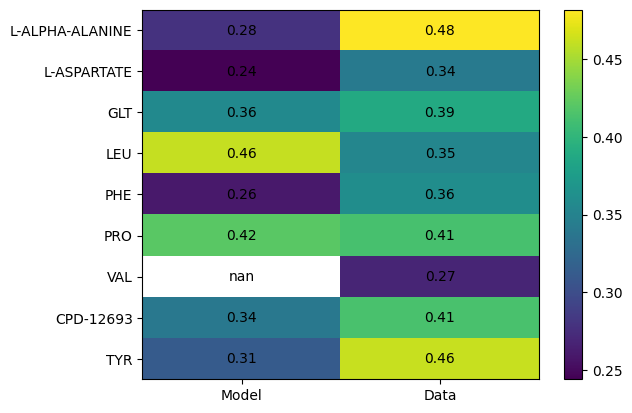

In [49]:
import matplotlib.pyplot as plt
from gem2cue import utils as cue
from cobra import Reaction, Metabolite

# Load BGE data
bge_data = pd.read_csv("../data/clean/growth/BGE_DSS3.csv")

# Get model BGE
model_bge = []
data_bge = []
substrates = []

co2_exchange="EX_co2"
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = model.reactions.get_by_id("EX_ac")
for substrate, bge in zip(bge_data["ID"], bge_data["BGE"]):
    # Record substrate
    substrates.append(substrate)

    # Record data bge
    data_bge.append(bge)

    # Record model BGE
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        with model:
            # Get internal metabolite
            met_c = model.metabolites.get_by_id(substrate + "[c]")

            # Get or create external metabolite
            try:
                met_e = model.metabolites.get_by_id(f"{substrate}[e]")
            except:
                met_e = Metabolite(f"{substrate}[e]",
                                   formula=met_c.formula,
                                   name=substrate,
                                   compartment="e")
                model.add_metabolites([met_e])

            # Set the substrate uptake rate
            set_active_bound(ex_glc, 0)
            set_active_bound(ex_ace, 0)
            ex_substrate = get_or_create_exchange(model, f"{substrate}[e]")
            set_active_bound(ex_substrate, 5)
            print(f"{ex_substrate} : {ex_substrate.bounds}")

            # Create a free transport reaction
            # TODO: add actual transport reactions
            transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
            transport.add_metabolites({
                met_e : -1,
                met_c : 1
            })
            model.add_reactions([transport])

            sol = model.optimize()
            if sol.status != "infeasible":
                c_ex_rxns = cue.get_c_ex_rxns(model)

                c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
                bge_model = cue.calculate_cue(c_uptake, c_secret, co2_exchange)
                model_bge.append(bge_model if bge_model is not None else float("nan"))
            else:
                model_bge.append(float("nan"))

# Plot model vs data BGE
fig, ax = plt.subplots()
img = ax.imshow(np.array([model_bge, data_bge]).T, cmap="viridis", aspect="auto")
for i, (_model_bge, _data_bge) in enumerate(zip(model_bge, data_bge)):
    ax.text(0, i, f"{_model_bge:.2f}", ha="center", va="center", color="black")
    ax.text(1, i, f"{_data_bge:.2f}", ha="center", va="center", color="black")

ax.set_xticks(range(2), ["Model", "Data"])
ax.set_yticks(range(len(substrates)), substrates)

fig.colorbar(img)

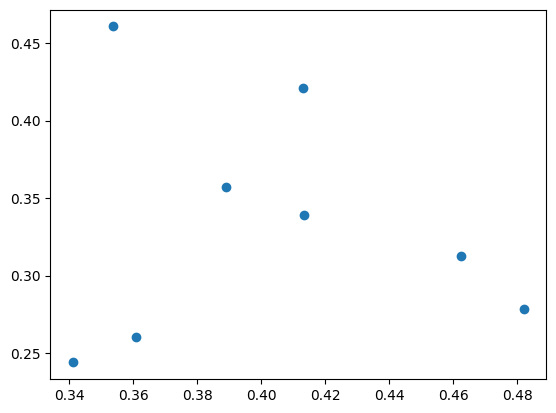

In [51]:
fig, ax = plt.subplots()
ax.scatter(data_bge, model_bge)

In [39]:
# Testing bed
# =============================================================================

substrate = "L-ALPHA-ALANINE"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with model:
        # Get internal metabolite
        met_c = model.metabolites.get_by_id(substrate + "[c]")

        # Get or create external metabolite
        try:
            met_e = model.metabolites.get_by_id(f"{substrate}[e]")
        except:
            met_e = Metabolite(f"{substrate}[e]",
                               formula=met_c.formula,
                               name=substrate,
                               compartment="e")
            model.add_metabolites([met_e])

        # Set the substrate uptake rate
        set_active_bound(ex_glc, 0)
        set_active_bound(ex_ace, 0)
        ex_substrate = get_or_create_exchange(model, f"{substrate}[e]")
        set_active_bound(ex_substrate, 3)
        print(f"{ex_substrate} : {ex_substrate.bounds}")

        # Create a free transport reaction
        # TODO: add actual transport reactions
        transport = Reaction("test", "", lower_bound=-1000, upper_bound=1000)
        transport.add_metabolites({
            met_e : -1,
            met_c : 1
        })
        model.add_reactions([transport])

        sol = model.optimize()
        if sol.status != "infeasible":
            assert ex_substrate in model.exchanges
            c_ex_rxns = cue.get_c_ex_rxns(model)
            assert ex_substrate in model.exchanges

            c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
            bge_model = cue.calculate_cue(c_uptake, c_secret, co2_exchange)
        else:
            bge_model = 0
        
        print(met_c.summary())

print(f"Solver status: {sol.status}")
print(f"Growth rate: {sol.objective_value}")
print(f"Model BGE: {bge_model}")
print(f"Data BGE: {bge_data.loc[bge_data['ID'] == substrate, 'BGE'].values[0]}")
print(f"Uptake fluxes: {c_uptake}")
print(f"Secretion fluxes: {c_secret}")


EX_L-ALPHA-ALANINE[e]: L-ALPHA-ALANINE[e] <=>  : (-3, 1000.0)
L-ALPHA-ALANINE[c]
Formula: C3H7NO2

Producing Reactions
-------------------
Percent Flux Reaction                                Definition
100.00%    3     test L-ALPHA-ALANINE[e] <=> L-ALPHA-ALANINE[c]

Consuming Reactions
-------------------
Percent       Flux                  Reaction                                                                      Definition
 99.68%      -2.99 ALANINE-DEHYDROGENASE-RXN L-ALPHA-ALANINE[c] + NAD[c] + WATER[c] --> AMMONIUM[c] + NADH[c] + PROTON[c]...
  0.02%  -0.000744            ALARACECAT-RXN                                             L-ALPHA-ALANINE[c] --> D-ALANINE[c]
  0.29%  -0.008671               PROTEIN-RXN 0.437725018 ARG[c] + 0.356722982 ASN[c] + 33.1963969 ATP[c] + 0.135523805 CY...
  0.01% -0.0002976    UDP-NACMUR-ALA-LIG-RXN ATP[c] + L-ALPHA-ALANINE[c] + UDP-N-ACETYLMURAMATE[c] --> ADP[c] + CPD0-1456...
Solver status: optimal
Growth rate: 0.020314533911148496
Model BGE: